# Import and Config

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from discofuzz.constants import SIMILARITY_METRICS
from discofuzz import FourierFuzzifier

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"GPU available: {gpus}")

# Define all available similarity metrics from FourierFuzzifier
sim_metrics_enum = [SIMILARITY_METRICS.COS, SIMILARITY_METRICS.W1, SIMILARITY_METRICS.W2, SIMILARITY_METRICS.Q]
sim_metrics = [s.value for s in sim_metrics_enum]
fuzzifier = FourierFuzzifier(
    sigma=0.1,
    kernel_size=8
)

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\igeek\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
c:\Users\igeek\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\igeek\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# Visualization Helpers

In [20]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec


class Visualizer:
    """Visualizes complex heatmaps built from Fourier series coefficients.

    Refactor: each 2D heatmap is shown with its 1D x- and y-distributions:
      - x distribution (from fx) plotted to the LEFT of the heatmap
      - y distribution (from fy) plotted UNDER the heatmap
    """

    def __init__(self, fuzzy_sample: np.ndarray, N: int = 200, figsize=(7, 6)) -> None:
        """
        Initialize the visualizer by computing:
          fx(x) and fy(y) from Fourier coefficients,
          H(x,y) = fx(x) * fy(y) on a [0,1) grid of size N.

        Args:
            fuzzy_sample: Fourier coefficients with shape (2, K).
            N: Grid resolution.
            figsize: Default figure size for single plots.
        """
        if fuzzy_sample.ndim != 2 or fuzzy_sample.shape[0] != 2:
            raise ValueError(f"Expected fuzzy_sample shape (2, K); got {fuzzy_sample.shape}")

        self.figsize = figsize
        self.N = int(N)

        self.x = np.linspace(0.0, 1.0, self.N, endpoint=False)
        self.fx, self.fy = self._compute_marginals(fuzzy_sample)
        self.H = (self.fx[:, None] * self.fy[None, :]).numpy()

    def _compute_marginals(self, fuzzy_sample: np.ndarray) -> tuple[tf.Tensor, tf.Tensor]:
        """Compute fx(x) and fy(y) from Fourier coefficients."""
        k = np.arange(fuzzy_sample.shape[1])
        basis = np.exp(1j * 2.0 * np.pi * np.outer(k, self.x))  # (K, N)

        fx = tf.math.reduce_sum(fuzzy_sample[0][:, None] * basis, axis=0)  # (N,)
        fy = tf.math.reduce_sum(fuzzy_sample[1][:, None] * basis, axis=0)  # (N,)
        return fx, fy


    def _get_view_specs(self, view: str):
        x = self.fx.numpy()
        y = self.fy.numpy()

        match view:
            case "real":
                data2d = self.H.real
                fx_vals = x.real
                fy_vals = y.real
                label = "Re"
            case "imag":
                data2d = self.H.imag
                fx_vals = x.imag
                fy_vals = y.imag
                label = "Im"
            case "magnitude":
                data2d = np.abs(self.H)
                fx_vals = np.abs(x)
                fy_vals = np.abs(y)
                label = "|H|"
            case "phase":
                data2d = np.angle(self.H)
                fx_vals = np.angle(x)
                fy_vals = np.angle(y)
                label = "arg(H)"
            case _:
                raise ValueError(f"Unknown view '{view}'")
        
        return data2d, fx_vals, fy_vals, label

    
    def plot(
        self,
        view: str = "magnitude",
        cmap: str = "viridis",
        line_kwargs: dict | None = None,
    ) -> None:
        """Plot one view as a heatmap with marginal 1D line plots (left: fy, bottom: fx)."""
        fig = plt.figure(figsize=self.figsize)
        self._plot_view_with_marginals(
            fig=fig,
            subspec=GridSpec(1, 1, figure=fig)[0],
            view=view,
            cmap=cmap,
            line_kwargs=line_kwargs,
            add_colorbar=True,
        )
        fig.tight_layout()
        plt.show()


    def plot_views(
        self,
        views: tuple[str, str, str, str] = ("real", "imaginary", "magnitude", "phase"),
        cmap: str = "viridis",
        line_kwargs: dict | None = None,
    ) -> None:
        """
        Plot multiple views together as subplots (default: real/imaginary/magnitude/phase).
        Each view is rendered with the same heatmap+marginals layout.
        """
        fig = plt.figure(figsize=(2 * self.figsize[0], 2 * self.figsize[1]))
        outer = GridSpec(2, 2, figure=fig, wspace=0.25, hspace=0.25)

        for i, view in enumerate(views):
            r, c = divmod(i, 2)
            self._plot_view_with_marginals(
                fig=fig,
                subspec=outer[r, c],
                view=view,
                cmap=cmap,
                line_kwargs=line_kwargs,
                add_colorbar=True,
            )

        fig.tight_layout()
        plt.show()

    def _plot_view_with_marginals(
        self,
        *,
        fig: plt.Figure,
        subspec,
        view: str,
        cmap: str,
        line_kwargs: dict | None,
        add_colorbar: bool,
    ) -> None:
        """Internal helper: one view (heatmap + marginals) inside a provided SubplotSpec."""
        if line_kwargs is None:
            line_kwargs = {"lw": 1.5}

        data2d, fx_vals, fy_vals, label = self._get_view_specs(view)

        # More breathing room so main labels don't sit under marginal axes
        inner = GridSpecFromSubplotSpec(
            2,
            2,
            subplot_spec=subspec,
            width_ratios=[1.0, 4.0],
            height_ratios=[4.0, 1.0],
            wspace=0.18,   # was 0.05
            hspace=0.18,   # was 0.05
        )

        ax_left = fig.add_subplot(inner[0, 0])
        ax_main = fig.add_subplot(inner[0, 1])
        ax_bottom = fig.add_subplot(inner[1, 1])

        # Make marginal axes transparent so they can't "paint over" neighboring labels
        ax_left.set_facecolor("none")
        ax_bottom.set_facecolor("none")
        ax_left.set_zorder(0)
        ax_bottom.set_zorder(0)
        ax_main.set_zorder(1)

        # --- Main heatmap ---
        im = ax_main.imshow(
            data2d,
            origin="lower",
            aspect="equal",
            extent=[0.0, 1.0, 0.0, 1.0],
            cmap=cmap,
        )
        ax_main.set_title(f"{view.capitalize()} of Components 0 and 1")

        # --- Left marginal (fy vs y) ---
        ax_left.plot(fy_vals, self.x, **line_kwargs)
        ax_left.set_ylabel("y ∈ [0, 1]", labelpad=6)
        ax_left.invert_xaxis()
        ax_left.grid(True, alpha=0.2)

        # Hide y tick labels/ticks to avoid competing with main plot
        ax_left.tick_params(axis="y", left=False, labelleft=False)

        # --- Bottom marginal (fx vs x) ---
        ax_bottom.plot(self.x, fx_vals, **line_kwargs)
        ax_bottom.set_xlabel("x ∈ [0, 1]", labelpad=4)
        ax_bottom.invert_yaxis()
        ax_bottom.grid(True, alpha=0.2)

        # Hide x tick labels/ticks to avoid competing with main plot
        ax_bottom.tick_params(axis="x", bottom=False, labelbottom=False)

        # --- Colorbar ---
        if add_colorbar:
            cbar = fig.colorbar(im, ax=ax_main, fraction=0.046, pad=0.04)
            cbar.set_label(label)


# Fuzzification

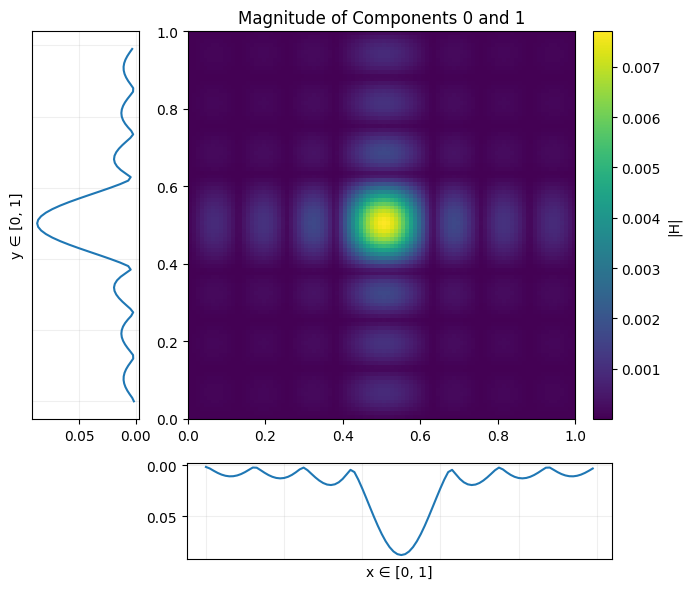

In [21]:
sample_pt = [0.5, 0.5]
fuzzy_sample = fuzzifier._get_gaussian_at_mu_batch(tf.constant(sample_pt))
visualizer = Visualizer(fuzzy_sample, 100)
visualizer.plot(view="magnitude")